In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl
# from sklearn import neighbors
# from sklearn.cluster import DBSCAN
import copy
# import emcee
import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from pyproj import Transformer

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, [1,500], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)


    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs

def foo(a, b):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

In [2]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32759")
das_x,das_y = transformer.transform(-77.659,168.141)

In [3]:


cable_loc = pd.read_csv('../cable_geometry/eastwind_coordinates_utm59s.csv', header=None)
cable_loc.rename(columns={0:'name', 1:'y', 2:'x', 3:'z'}, inplace=True)

cable_sections = [[0,132],[133,136], [137,192],[193,217],[218,285],[286,291],[292,350]]
cable_loc_names = [['D_0','D_12'],['D_12','D_17'], ['D_17','D_26'],['D_26','D_31'],['D_31','D_40'],['D_40','D_43'],['D_43','D_49']]

y_offset = cable_loc['y'][0] - das_y
x_offset = cable_loc['x'][0] - das_x

channel_locations = []
for chan_num, ceble_name in zip(cable_sections, cable_loc_names):

    x_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'x'].iloc[0] - x_offset
    x_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'x'].iloc[0] - x_offset

    y_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'y'].iloc[0] - y_offset
    y_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'y'].iloc[0] - y_offset

    z_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'z'].iloc[0]
    z_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'z'].iloc[0]

    x_vals = np.linspace(x_start, x_end, chan_num[1]-chan_num[0]+1)
    y_vals = np.linspace(y_start, y_end, chan_num[1]-chan_num[0]+1)
    z_vals = np.linspace(z_start, z_end, chan_num[1]-chan_num[0]+1)

    for x,y,z in zip(x_vals, y_vals, z_vals):
        channel_locations.append([x,y,z])

channel_locations = np.asarray(channel_locations)


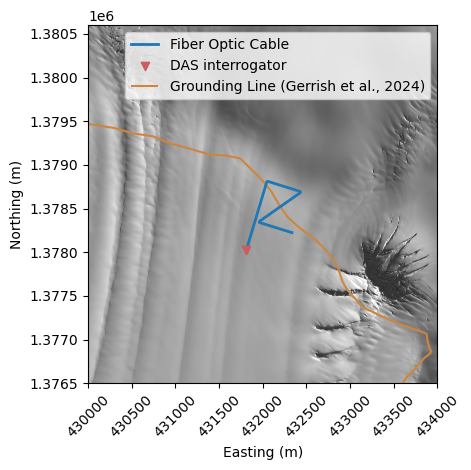

In [4]:
from rasterio.plot import show

# Specify the path to the GeoPackage file
gpkg_path = "../imagery/eastwind_image_reproject_AOI_clip.tif"

fig,ax = plt.subplots()


# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

    # Process or visualize the image data
    # For example, to display the image using matplotlib:
    show(image_data, transform=src.transform, ax=ax) 
    # ax.imshow(image_data[0], cmap='gray') # Assuming single-band image, adjust as needed


ax.plot(channel_locations[:,0], channel_locations[:,1], lw=2, label='Fiber Optic Cable', zorder=1)
ax.scatter(channel_locations[0,0], channel_locations[0,1],
           c='indianred', marker='v', label='DAS interrogator', zorder=2)

gdf_gl = gpd.read_file("../groundingline_shapefiles/add_coastline_high_res_line_v7_10.shp").to_crs(epsg=32759)
gdf_gl.plot(ax=ax, color='peru', label='Grounding Line (Gerrish et al., 2024)', zorder=0 )
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

ax.set_xlim([430000, 434000])
ax.set_ylim([1.3765e6, 1.3806e6])

ax.xaxis.set_tick_params(rotation=45)

plt.legend()
plt.tight_layout()

# plt.savefig('cable_map.png', dpi=300, transparent=True)
plt.show()

In [25]:
transformer = Transformer.from_crs("EPSG:32759", "EPSG:4326")
wgs_lat, wgs_lon = transformer.transform(channel_locations[:,0], channel_locations[:,1])

In [19]:
channel_frame = pd.DataFrame({'Latitude':channel_locations[:,1],'Longitude':channel_locations[:,0],'Elevation':channel_locations[:,2], 'Name':['Channel ' + str(i) for i in range(channel_locations.shape[0])]})

channel_frame.to_csv('../cable_geometry/eastwind_DAS_cable_info.txt', index=None, sep=',', mode='a')

In [26]:
channel_frame = pd.DataFrame({'Latitude':wgs_lat,'Longitude':wgs_lon,'Elevation':channel_locations[:,2], 'Name':['Channel ' + str(i) for i in range(channel_locations.shape[0])]})
channel_frame.to_csv('../cable_geometry/eastwind_DAS_cable_info_wgs84.txt', index=None, sep=',', mode='a')
